In [51]:
# calcium traces exploration - simple commands in pandas
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import scipy.stats
import os
import pickle
from matplotlib import cm
from sklearn.model_selection import KFold, cross_validate, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import RidgeClassifierCV, RidgeCV
from sklearn.metrics import accuracy_score, confusion_matrix
from pyriemann.tangentspace import TangentSpace
from sklearn.kernel_ridge import KernelRidge
from scipy.spatial.distance import mahalanobis
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics.pairwise import pairwise_distances
import pyriemann.utils.distance as rd
from sklearn.metrics import mean_squared_error, explained_variance_score
from scipy.stats import zscore
import os
import pickle
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import pairwise_kernels

In [2]:
# first define some functios that you will use

In [3]:

def compute_pairwise_riemann_distance(cov_mat_single_ws):
    """ Function that computes riemann distance pairwise in case of analysis with custom kernel ridge.
        input should be covariance or correlation matrix"""
    n_trials, n_units, _, n_time_points = cov_mat_single_ws.shape
    D_riemann = np.zeros(shape=(n_trials, n_trials, n_time_points))
    for t_i in range(n_time_points):
        D_riemann[:,:,t_i] = rd.pairwise_distance(cov_mat_single_ws[:, :, :, t_i], metric='riemann')
    return D_riemann

In [4]:
def project_to_tg_space(cov_mat_single_ws):
    """ Function that uses the pyriemann library to project the input to their tangent space in Riemann Geometry.
    Used to reduce dimensions of input where euclidean distance is not necessarily meaningful,
    e.g. for the case of correlation/covariance"""
    n_time_points = cov_mat_single_ws.shape[3]
    n_units = cov_mat_single_ws.shape[1]
    n_trials = cov_mat_single_ws.shape[0]
    # create tangent space projection of the covariance matrices.
    ts = TangentSpace(metric='riemann')
    n_ts = int((n_units * (n_units + 1)) / 2)
    single_ws_input = np.zeros(shape=(n_trials, n_ts, n_time_points))
    # project every covariance matrix into tangent space
    for t_i in range(n_time_points):
        single_ws_input[:, :, t_i] = ts.fit_transform(cov_mat_single_ws[:, :, :, t_i])

    return single_ws_input

In [5]:

def compute_inv_cov_mat(X, time_last=True):
    """ function that computes vi, the inverse of the covariance matrix of the input X.
    This information is needed to compute mahalanobis distance in case of analysis custom kernel ridge.
    It assumes X of shape (n_trials, n_units, n_time_points)"""
    if time_last:
        X = np.transpose(X, (2, 0, 1))

    n_time_points = X.shape[0]
    n_trials = X.shape[1]
    n_units = X.shape[2]
    X = np.reshape(X, (n_time_points * n_trials, n_units))
    cov_mat = np.cov(X, rowvar=False)
    vi = scipy.linalg.inv(cov_mat)
    return vi


In [6]:
class SlidingWindow(object):
    def __init__(self, window_size, data):
        self.ws = window_size
        self.half_w = int(self.ws/2)
        self.data = data
        self.list_length = self.data.shape[1]

    def slide_window(self, current_index):
        if current_index <= self.half_w:
            sel_data = self.data[:, 0:current_index + self.half_w]
        elif current_index >= self.list_length - self.half_w:
            sel_data = self.data[:, current_index - self.half_w:-1]
        else:
            sel_data = self.data[:, current_index-self.half_w: current_index+self.half_w]

        return sel_data


In [7]:
from pyriemann.estimation import Covariances
def create_sw_cov_or_corr_matrix(inputs, analysis_type, sliding_window_size):
    # mat_cov_all = np.zeros(shape=(n_windows, n_trials, n_units, n_units, n_time_points))
    n_trials, n_units, n_time_points = inputs.shape

    output_mat = np.zeros(shape=(n_trials, n_units, n_units, n_time_points))

    # loop on trials
    for k in range(n_trials):
        slider = SlidingWindow(sliding_window_size, inputs[k, :, :])

        for t in range(n_time_points):
            window_data = slider.slide_window(t)
            # mat_cov_all[s, k, :, :, t] = np.cov(window_data)
            if analysis_type == 'cov_mat':
                output_mat[k, :, :, t] = np.cov(window_data)
            elif analysis_type == 'corr_mat':
                output_mat[k, :, :, t] = np.corrcoef(window_data)

    return output_mat

In [8]:
from pyriemann.estimation import Covariances
def create_sw_cov_reg_matrix(inputs, analysis_type, sliding_window_size):
    # mat_cov_all = np.zeros(shape=(n_windows, n_trials, n_units, n_units, n_time_points))
    n_trials, n_units, n_time_points = inputs.shape

    output_mat = np.zeros(shape=(n_trials, n_units, n_units, n_time_points))

    # loop on trials
    for k in range(n_trials):
        slider = SlidingWindow(sliding_window_size, inputs[k, :, :])

        for t in range(n_time_points):
            window_data = slider.slide_window(t)
            # mat_cov_all[s, k, :, :, t] = np.cov(window_data)
            if analysis_type == 'cov_mat':
                output_mat[k, :, :, t] = Covariances('oas').fit_transform(window_data)
            elif analysis_type == 'corr_mat':
                output_mat[k, :, :, t] = np.corrcoef(window_data)

    return output_mat

In [9]:
# define function for diag analysis
class DiagonalAnalysisCV(object):
    """ This class initializes a similar kind of analysis as the previous class
    but it only performs train and test on the same time point.
    Especially used for computationally expensive analyses, like the custom kernel,
    or for pilot analyses on new data."""
    def __init__(self, kf, model_pipeline, accuracy_metric='explained_variance'):
        self.model = model_pipeline
        self.kf = kf
        self.acc_metric = accuracy_metric

    def run_analysis(self, X, y, K_FOLD_NUMBER):
        n_trials, n_units, n_time_points = X.shape
        accuracy_stored = np.zeros(shape=(n_time_points, K_FOLD_NUMBER))
        indices = np.arange(n_trials)

        # loop on kfold splits
        k = 0
        for train_index, test_index in self.kf.split(indices):
            # split everything into train and test
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            print(X_train.shape)
            print(y_train.shape)

            # train on one time point
            for t_i in range(n_time_points):
                # create all training test split
                X_train_timepoint = X_train[:, :, t_i]
                #y_train_timepoint = y_train[:,t_i]
                X_test_timepoint = X_test[:,:, t_i]
                #y_test_timepoint = y_test[:,t_i]
                self.model.fit(X_train_timepoint, y_train)
                y_pred_timepoint = self.model.predict(X_test_timepoint)
                if self.acc_metric == "classification":
                    accuracy_stored[t_i, k] = accuracy_score(y_test, np.sign(y_pred_timepoint))
                elif self.acc_metric == "explained_variance":
                    accuracy_stored[t_i, k] = explained_variance_score(y_test, y_pred_timepoint)

            print("mean overall accuracy fold %d" % k)
            print(np.mean(accuracy_stored[:, k]))
            k += 1

        return accuracy_stored


In [19]:
# Define loading data conditions

##### change chosen animal!! ######
chosen_animal = 233
##### change chosen session!! ######
#### change session number here
session = "12"


if chosen_animal == 232:
    animal_folder_name = "/media/share/16.1/Data/Felipes_data/calcium_imaging/animal_232/"
    non_airpuff_sessions = ['04','06','07','08','10','11','12','13'] # animal 232
    airpuff_sessions = ['14','16','17','18','19'] # animal 232
    all_sessions = ['04','06','07','08','10','11','12','13','14','16','17','18','19'] # animal 232
    calcium_traces_folder_name = "Calcium_Traces/"
    calcium_base_filename = "2021-05-"
    bhv_info_folder_name = "laura"
    
    
elif chosen_animal ==233:
    animal_folder_name = "/media/share/16.1/Data/Felipes_data/calcium_imaging/animal_233/"
    non_airpuff_sessions = ['06','07','08','09','10','11','12','13'] # animal 233
    airpuff_sessions = ['14','15','16','17','18','19'] # animal 233
    all_sessions = ['06','07','08','09','10','11','12','13','14','15','16','17','18','19'] # animal 233
    calcium_traces_folder_name = "Calcium_Traces/"
    calcium_base_filename = "2021-05-"
    bhv_info_folder_name = "trial_info"

else:
    raise AssertionError('choose an available animal!')



In [20]:
# load csv calcium traces
folder_name = "Calcium_Traces/"
filename = "2021-05-{0}.csv".format(session)
df = pd.read_csv(os.path.join(animal_folder_name,folder_name, filename))
n_rows, n_columns = df.shape
# display the top of the table
#df.head()

# EXTRACT THE DATA YOU WILL NEED FOR THE ANALYSIS
# as you can see from the head, first row is useless, the first column is time, all the other columns are channels
# calcium data are sampled at 100 msec. 
# create time array
df_times = df[' '][1:-1]
df_num_time = pd.to_numeric(df_times, downcast='float')
time_array = df_num_time.to_numpy()
tot_timepoints = len(time_array)

# check time sampling - i.e. if every data point is taken at the same "distance" in time from the next - or previous
time_sampling = np.zeros(shape=(len(time_array)-1,))
for i in range(1,len(time_array)):
    time_sampling[i-1] = time_array[i]-time_array[i-1]

#plt.plot(np.arange(len(time_array)-1), time_sampling, '.')
#plt.show()

#12420 timepoints sampled at 100msec. means that every 10 of those timepoints is 1 sec
sampling_rate = 0.1
tot_secs = int(tot_timepoints * sampling_rate)

# create channels array
n_channels = n_columns-1
channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
# fill empty channels array
for i in range(n_channels):
    col_name = df.columns[i+1]
    df_channel = df[col_name][1:-1]
    df_num_channel = pd.to_numeric(df_channel, downcast='float')
    channels_array[:,i] = df_num_channel.to_numpy()

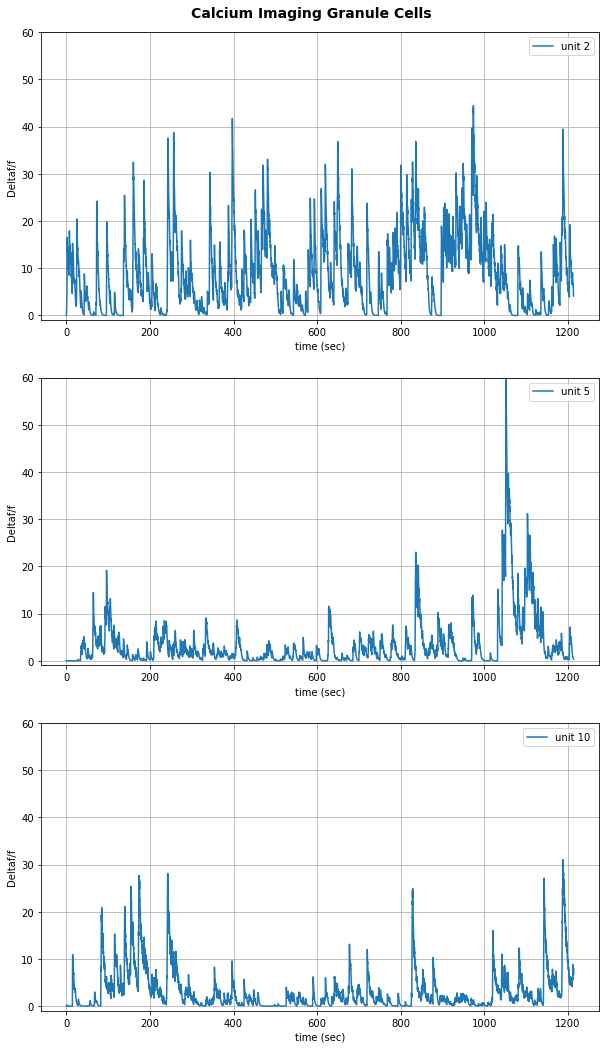

In [21]:
# check your data - plot some channels
units = [2,5,10]
fig, axs = plt.subplots(len(units),1, figsize=(10,18))

for u in range(len(units)):
    axs[u].plot(time_array,channels_array[:,units[u]], label='unit %d'%units[u])
    axs[u].set_xlabel('time (sec)')
    axs[u].set_ylabel('Deltaf/f')
    #axs[u].set_ylim([-0.001,0.01])
    axs[u].set_ylim([-1,60])
    axs[u].grid()
    axs[u].legend()
    
fig.suptitle('Calcium Imaging Granule Cells', y=0.9, fontsize=14, fontweight='bold')
plt.show()

In [22]:

# LOAD BEHAVIOURAL DATA
if chosen_animal == 233:
    bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
    trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

    # extract information from trial_info: in matlab this is a struct with the fields:
    trials_start_time = trial_info['trial_info'][0,0][0].ravel()
    trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
    trials_response = trial_info['trial_info'][0,0][2].ravel()
    trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
    trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
    trials_end_time = trial_info['trial_info'][0,0][5].ravel()
    n_trials = len(trials_end_time) # number of trials

elif chosen_animal== 232:
    # CORRUPTED FILES - LOAD LAURA'S NEW VERSION

    bhv_info_filename = "trial_info_232laura_202105{0}.mat".format(session)
    trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

    # extract information from trial_info: in MATLAB this is a struct with the fields:
    trials_start_time = trial_info['trial_start_new'][0].ravel()
    trials_stimulus_on = trial_info['trial_stimulus_on'][0].ravel()
    trials_response = trial_info['trial_response'][0].ravel()
    trials_is_right_lick = trial_info['trial_is_right_lick'][0].ravel()
    trials_is_reward = trial_info['trial_is_reward'][0].ravel()
    trials_end_time = trial_info['trial_end_new'][0].ravel()
    n_trials = len(trials_end_time)
    

# restructure trials such that the waiting time before stimulus onset goes to the end of the previous trial

new_start = trials_stimulus_on - 0.5
new_end = np.zeros(shape=(n_trials,))

new_end[0:-1] = trials_stimulus_on[1:]-0.5
new_end[-1] = trials_end_time[-1]

    
# where was the stimulus? we don't have this info. But it can be reconstructed 
stimulus_reconstruction = np.zeros(shape=(n_trials,))
right_choice = np.where(trials_is_reward==1)[0]
stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
wrong_choice = np.where(trials_is_reward==0)[0]
stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

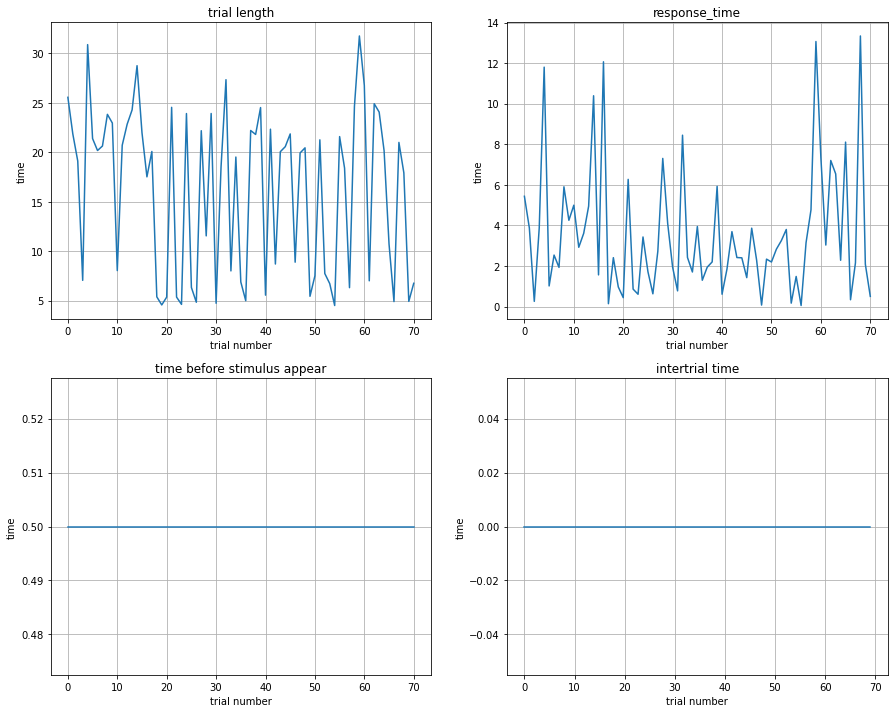

In [23]:
# trial length, response time, time before stimulus appears and intertrial time
fig, axs = plt.subplots(2,2,figsize=(15,12))
trials_length = new_end - new_start
response_time = trials_response - trials_stimulus_on
stim_time = trials_stimulus_on - new_start
intertrial_time = []
for i in range(1,n_trials):
    intertrial_time.append(new_start[i] - new_end[i-1])

# plot variables in subplots
axs[0, 0].plot(np.arange(n_trials), trials_length)
axs[0, 0].set_title('trial length')
axs[0, 1].plot(np.arange(n_trials), response_time)
axs[0, 1].set_title('response_time')
axs[1, 0].plot(np.arange(n_trials), stim_time)
axs[1, 0].set_title('time before stimulus appear')
axs[1, 1].plot(np.arange(n_trials-1), intertrial_time)
axs[1, 1].set_title('intertrial time')

# label axes
for ax in axs.flat:
    ax.set(xlabel='trial number', ylabel='time')
    ax.grid()
    
plt.show()

In [24]:
# split traces data into trials
X = {}
for i in range(n_trials):
    lower_bound = np.min(np.where(time_array>=new_start[i]))
    upper_bound = np.max(np.where(time_array<=new_end[i]))
    X[i] = channels_array[lower_bound:upper_bound,:]

In [25]:
# align data at points of interest
# create the data array you will need to use as X with shape [n_trials, n_channels, n_timepoints]
# depending on what you want to test you will need to create different X

# trials have different length. Here Align them at the response, 
# and take the amount of points available in all trials around the response 


n_before_resp = 5 # number of timepoints before response - 500msec
n_after_resp = 15 # number of timepoints after response - 1500msec / 1.5sec
n_timepoints = n_before_resp+ n_after_resp # total number of timepoints in time window

X_response = np.zeros(shape=(n_trials-1, n_timepoints , n_channels ))

for i in range(n_trials-1):
    resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
    x = X[i][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp]
    X_response[i] = x

# transpose to have X in shape [n_trials, n_channels, n_timepoints]
X_response = X_response.transpose(0,2,1)


In [24]:
trials_response[78] - new_start[78]

5.61200000000008

In [25]:
6.3 - 5.6

0.7000000000000002

In [26]:
## COMPUTE SLIDING WINDOW COVARIANCES ###

SLIDING_WINDOWS_SIZE = [5,7,9]
analysis_type = "cov_mat"

cov_mat_tot = {}

for ws in SLIDING_WINDOWS_SIZE:
    mat_single_ws = np.zeros(shape=(n_trials-1,n_channels,n_channels, n_timepoints-ws+1))
    for t in range(int(ws/2),n_timepoints-int(ws/2)):
        mat_single_ws[:,:,:,t-int(ws/2)] = Covariances('oas').fit_transform(X_response[:,:,t-int(ws/2):t+int(ws/2)])
    cov_mat_tot[ws] = mat_single_ws



In [18]:
# project to tangent space
inputs = {}
for ws in SLIDING_WINDOWS_SIZE:
    single_ws_input = project_to_tg_space(cov_mat_tot[ws])
    print("tangent space projection ready for ws %d" % ws)

    inputs[ws] = single_ws_input

KeyError: 5

In [63]:
ANALYSIS_ALGORITHM = "rbf_kernel_ridge"
# other parameters to cross validate for
ALPHA = [0.01, 0.01, 0.1, 1, 10] # ridge penalization
#GAMMA = [0.01, 0.1, 1] # kernel width
K_FOLD_NUMBER = 5

accuracy_metric='explained_variance'
kf = KFold(n_splits=K_FOLD_NUMBER, shuffle=True, random_state=1)
diagonal_acc = {}

In [64]:
decode_str = 'reward_or_punish'
y = trials_is_reward[0:-1]

# ANALYSIS ALL 
print("all units decoding - response aligned - %s" %decode_str)

overall_class_balance = np.mean(y)
print("%s class balance: "%decode_str)
print(overall_class_balance)


for ws in SLIDING_WINDOWS_SIZE:
    param_grid = {"alpha": ALPHA, "gamma": GAMMA}
    grid_search = GridSearchCV(KernelRidge(kernel='rbf'), param_grid=param_grid)


    cross_validation_analysis = DiagonalAnalysisCV(kf, grid_search, accuracy_metric=accuracy_metric)
    diagonal_acc[ws] = cross_validation_analysis.run_analysis(inputs[ws], y, K_FOLD_NUMBER)
    
    
    print("Analysis finished for ws %d"%ws)


all units decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.4727272727272727


NameError: name 'SLIDING_WINDOWS_SIZE' is not defined

In [ ]:
# plot reward or punishment at response
for ws in SLIDING_WINDOWS_SIZE:
    fig = plt.figure()
    plt.plot(np.arange(n_timepoints-ws+1), np.mean(diagonal_acc[ws], axis=1),'r')
    #plt.plot(np.arange(n_timepoints-ws+1), np.ones(shape=(n_timepoints-ws+1,))*overall_class_balance, '--b', label="chance")
    plt.axvline(x=n_before_resp-int(ws/2), color='k', label="response")
    plt.ylim([-0.2,1])
    plt.grid()
    plt.legend()
    plt.xlabel('time - response aligned')

    plt.ylabel('cross validated explained variance')
    title_str = "decoding %s \n from correlations - ws = %d \n animal %d, session %s"%(decode_str, ws, chosen_animal, session)       
    plt.title(title_str, fontweight='bold')
    plt.show()

# AVERAGE DECODING ACROSS SESSIONS

In [92]:
#### change chosen animal!!
chosen_animal = 233

if chosen_animal == 232:
    animal_folder_name = "/media/share/16.1/Data/Felipes_data/calcium_imaging/animal_232/"
    non_airpuff_sessions = ['04','06','07','08','10','11','12','13'] # animal 232
    airpuff_sessions = ['14','16','17','18','19'] # animal 232
    all_sessions = ['04','06','07','08','10','11','12','13','14','16','17','18','19'] # animal 232
    calcium_traces_folder_name = "Calcium_Traces/"
    calcium_base_filename = "2021-05-"
    bhv_info_folder_name = "laura"
    
    # !!!!!!!!!!!!!!! took out session 11 from animal 233 for inconsistent trials length - double check
elif chosen_animal ==233:
    animal_folder_name = "/media/share/16.1/Data/Felipes_data/calcium_imaging/animal_233/"
    non_airpuff_sessions = ['06','07','08','09','10','12','13'] # animal 233 # !!!!!!!!!!!!!!!
    airpuff_sessions = ['14','15','16','17','18','19'] # animal 233
    all_sessions = ['06','07','08','09','10','11','12','13','14','15','16','17','18','19'] # animal 233
    calcium_traces_folder_name = "Calcium_Traces/"
    calcium_base_filename = "2021-05-"
    bhv_info_folder_name = "trial_info"

else:
    raise AssertionError('choose an available animal!')



In [93]:
## ALIGN AT RESPONSE, with most data after - MAKES MORE SENSE FOR ANIMAL 232 

In [100]:
corr_ws = 7
session_cvev_rew_resp_corr = []
session_cvev_rew_resp_units = []

ANALYSIS_ALGORITHM = "rbf_kernel_ridge"
# other parameters to cross validate for
ALPHA = [0.01, 0.01, 0.1, 1, 10] # ridge penalization
#GAMMA = [0.01, 0.1, 1] # kernel width
K_FOLD_NUMBER = 5

accuracy_metric='explained_variance'
decode_str = 'reward_or_punish'

# also compare with units decoding



sampling_rate=0.1
# for each airpuff session:
for session in airpuff_sessions:

    # LOAD CSV CALCIUM TRACES 
    calcium_session_filename = calcium_base_filename + session + '.csv' 
    df = pd.read_csv(os.path.join(animal_folder_name,calcium_traces_folder_name, calcium_session_filename))
    n_rows, n_columns = df.shape

    # create time array
    df_times = df[' '][1:-1]
    df_num_time = pd.to_numeric(df_times, downcast='float')
    time_array = df_num_time.to_numpy()
    tot_timepoints = len(time_array)

    #create channels array
    n_channels = n_columns-1
    channels_array = np.zeros(shape=(tot_timepoints, n_channels)) # initiate empty array
    # fill empty channels array
    for i in range(n_channels):
        col_name = df.columns[i+1]
        df_channel = df[col_name][1:-1]
        df_num_channel = pd.to_numeric(df_channel, downcast='float')
        channels_array[:,i] = df_num_channel.to_numpy()

    # LOAD BEHAVIOURAL DATA
    if chosen_animal == 233:
        bhv_info_filename = "trial_info_2021-05-{0}.mat".format(session)
        trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

        # extract information from trial_info: in matlab this is a struct with the fields:
        trials_start_time = trial_info['trial_info'][0,0][0].ravel()
        trials_stimulus_on = trial_info['trial_info'][0,0][1].ravel()
        trials_response = trial_info['trial_info'][0,0][2].ravel()
        trials_is_right_lick = trial_info['trial_info'][0,0][3].ravel()
        trials_is_reward = trial_info['trial_info'][0,0][4].ravel()
        trials_end_time = trial_info['trial_info'][0,0][5].ravel()
        n_trials = len(trials_end_time) # number of trials
    
    
    elif chosen_animal== 232:
        # CORRUPTED FILES - LOAD LAURA'S NEW VERSION

        bhv_info_filename = "trial_info_232laura_202105{0}.mat".format(session)
        trial_info = scipy.io.loadmat(os.path.join(animal_folder_name,bhv_info_folder_name, bhv_info_filename))

        # extract information from trial_info: in MATLAB this is a struct with the fields:
        trials_start_time = trial_info['trial_start_new'][0].ravel()
        trials_stimulus_on = trial_info['trial_stimulus_on'][0].ravel()
        trials_response = trial_info['trial_response'][0].ravel()
        trials_is_right_lick = trial_info['trial_is_right_lick'][0].ravel()
        trials_is_reward = trial_info['trial_is_reward'][0].ravel()
        trials_end_time = trial_info['trial_end_new'][0].ravel()
        n_trials = len(trials_end_time)
    

    # restructure trials such that the waiting time before stimulus onset goes to the end of the previous trial

    new_start = trials_stimulus_on - 0.5
    new_end = np.zeros(shape=(n_trials,))

    new_end[0:-1] = trials_stimulus_on[1:]-0.
    new_end[-1] = trials_end_time[-1]

    
    # where was the stimulus? we don't have this info. But it can be reconstructed 
    stimulus_reconstruction = np.zeros(shape=(n_trials,))
    right_choice = np.where(trials_is_reward==1)[0]
    stimulus_reconstruction[right_choice] = trials_is_right_lick[right_choice]
    wrong_choice = np.where(trials_is_reward==0)[0]
    stimulus_reconstruction[wrong_choice] = 1 - trials_is_right_lick[wrong_choice]

    # split traces data by trials
    X = {}
    for i in range(n_trials-1):
        lower_bound = np.min(np.where(time_array>=new_start[i]))
        upper_bound = np.max(np.where(time_array<=new_end[i]))
        X[i] = channels_array[lower_bound:upper_bound,:]

    # align data at response
    
    n_before_resp = 5 # number of timepoints before response - 500msec
    n_after_resp = 15 # number of timepoints after response - 1500msec / 1.5sec
    n_timepoints = n_before_resp+ n_after_resp # total number of timepoints in time window
    X_response = np.zeros(shape=(n_trials-1, n_timepoints , n_channels ))

    for i in range(n_trials-1):
        resp_timepoint = int((trials_response[i] - new_start[i]) / sampling_rate)
        x = X[i][resp_timepoint-n_before_resp:resp_timepoint+n_after_resp]
        X_response[i] = x

    # transpose to have X in shape [n_trials, n_channels, n_timepoints]
    X_response = X_response.transpose(0,2,1)
    
    ## COMPUTE SLIDING WINDOW COVARIANCE ###
    analysis_type = "cov_mat"
    mat_single_ws = np.zeros(shape=(n_trials-1,n_channels,n_channels, n_timepoints-corr_ws+1))
    for t in range(int(corr_ws/2),n_timepoints-int(corr_ws/2)):
        mat_single_ws[:,:,:,t-int(corr_ws/2)] = Covariances('oas').fit_transform(X_response[:,:,t-int(corr_ws/2):t+int(corr_ws/2)])
    
    ## project to tangent space
    single_ws_input = project_to_tg_space(mat_single_ws)
    kf = KFold(n_splits=K_FOLD_NUMBER, shuffle=True, random_state=1)
    
    y = trials_is_reward[0:-1]

    # ANALYSIS ALL 
    print("SESSION %s - corr decoding - response aligned - %s" %(session, decode_str))

    overall_class_balance = np.mean(y)
    print("%s class balance: "%decode_str)
    print(overall_class_balance)

    param_grid = {"alpha": ALPHA}#, "gamma": GAMMA}
    #grid_search = GridSearchCV(KernelRidge(kernel='rbf'), param_grid=param_grid)
    grid_search_corr = GridSearchCV(Ridge(), param_grid=param_grid)
    cross_validation_analysis_corr = DiagonalAnalysisCV(kf, grid_search_corr, accuracy_metric=accuracy_metric)
    diagonal_acc_corr = cross_validation_analysis_corr.run_analysis(single_ws_input, y, K_FOLD_NUMBER)
    session_cvev_rew_resp_corr.append(diagonal_acc_corr)

    print("Analysis finished for cov matrices on session %s "%session)

    grid_search_units = GridSearchCV(Ridge(), param_grid=param_grid)
    cross_validation_analysis_units = DiagonalAnalysisCV(kf, grid_search_units, accuracy_metric=accuracy_metric)
    diagonal_acc_units = cross_validation_analysis_units.run_analysis(X_response[:,:,int(corr_ws/2):n_timepoints-int(corr_ws/2)], y, K_FOLD_NUMBER)
    session_cvev_rew_resp_units.append(diagonal_acc_units)
    print ("Analysis finished for units on session %s "%session)
    


SESSION 14 - corr decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.4666666666666667
(48, 1953, 14)
(48,)
mean overall accuracy fold 0
0.35020932557021317
(48, 1953, 14)
(48,)
mean overall accuracy fold 1
0.4969390577701566
(48, 1953, 14)
(48,)
mean overall accuracy fold 2
0.43414645933158547
(48, 1953, 14)
(48,)
mean overall accuracy fold 3
0.42919912252078196
(48, 1953, 14)
(48,)
mean overall accuracy fold 4
0.29105707951069454
Analysis finished for cov matrices on session 14 
(48, 62, 14)
(48,)
mean overall accuracy fold 0
-0.9605618953546929
(48, 62, 14)
(48,)
mean overall accuracy fold 1
-1.0004691368438638
(48, 62, 14)
(48,)
mean overall accuracy fold 2
-2.622825103002646
(48, 62, 14)
(48,)
mean overall accuracy fold 3
-2.150655030569694
(48, 62, 14)
(48,)
mean overall accuracy fold 4
-2.5654568822410972
Analysis finished for units on session 14 
SESSION 15 - corr decoding - response aligned - reward_or_punish
reward_or_punish class balance: 
0.526

In [101]:
# do some statistical testing
import copy
import random


array_units_cvev = np.array(session_cvev_rew_resp_units).transpose(0,2,1)
array_cov_cvev = np.array(session_cvev_rew_resp_corr).transpose(0,2,1)

# set this in recurrent loop to test all significances
shape1,shape2,shape3 = array_cov_cvev.shape
#############################################################################################
pval = np.zeros(shape=(shape3))

for t in range(shape3):
    # change variable1 and variable2 to compute permutation and t-tests between them:
    # first_var_start  first_var_stim_onset  first_var_resp  first_var_punish  first_var_reward
    variable1 = array_units_cvev[:,:,t].reshape(shape1*shape2,)
    variable2 = array_cov_cvev[:,:,t].reshape(shape1*shape2,)


    # Compute the ground truth absolute difference Δτ between τ₁ and τ₂ from your two variables:
    gT = np.abs(np.mean(variable1) - np.mean(variable2))

    # Pool your variables into one single distribution:
    pV = list(variable1) + list(variable2)

    # Copy pooled distribution:
    pS = copy.copy(pV)
    # Initialize permutation:
    pD = []
    # Define p (number of permutations):
    p=10000
    # Permutation loop:
    for k in range(0,p):
       
        random.shuffle(pS)
        surrogate_var1 = pS[0:int(len(pS)/2)]
        surrogate_var2 = pS[int(len(pS)/2):]

        # Compute permuted absolute difference of your two sampled distributions and store it in pD:
        pD.append(np.abs(np.mean(surrogate_var1) - np.mean(surrogate_var2)))

        # Finally, the proportion of permuted differences higher than your ground truth difference 
        # is your significance value:
        # is there any permutation where the difference between the surrogate distributions is hi
        
    pval[t] = np.sum(np.array(pD)>=np.array(gT))/p

In [102]:
pval

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

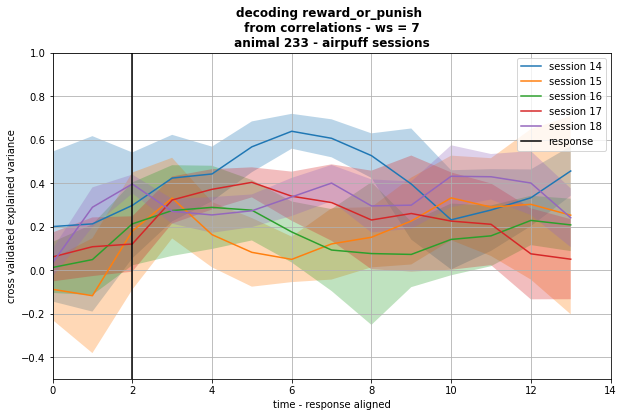

In [104]:
# plot reward or punishment at response per session
fig = plt.figure(figsize=(10,6))
for i in range(len(session_cvev_rew_resp)):
    # mean and variance shaded to add
    label_i = 'session %s'%airpuff_sessions[i]
    mean_y = np.mean(session_cvev_rew_resp_corr[i], axis=1)
    
    plt.plot(np.arange(n_timepoints-corr_ws+1), mean_y, label=label_i)
    err = np.std(session_cvev_rew_resp[i], axis=1)
    plt.fill_between(np.arange(n_timepoints-corr_ws+1), mean_y-err,mean_y+err, alpha=0.3)
    #plt.plot(np.arange(n_timepoints-ws+1), np.ones(shape=(n_timepoints-ws+1,))*overall_class_balance, '--b', label="chance")
plt.axvline(x=n_before_resp-int(corr_ws/2), color='k', label="response")
plt.xlim([0,14])
plt.ylim([-0.5,1])
plt.grid()
#plt.legend(bbox_to_anchor=(0., 0., 0.48, 0.48))
plt.legend(loc='upper right')
plt.xlabel('time - response aligned')
plt.ylabel('cross validated explained variance')
title_str = "decoding %s \n from correlations - ws = %d \n animal %d - airpuff sessions "%(decode_str, corr_ws, chosen_animal)       
plt.title(title_str, fontweight='bold')
plt.show()

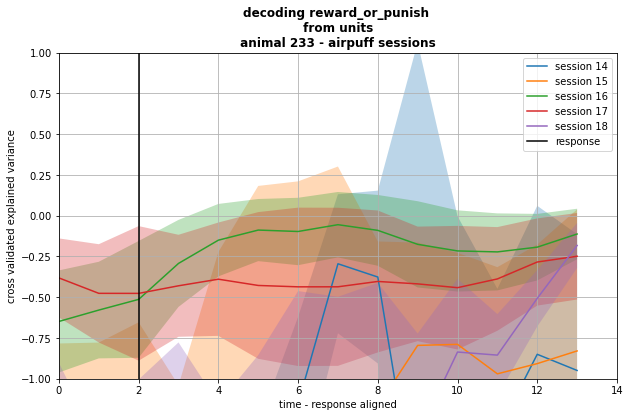

In [103]:
# plot reward or punishment at response per session
fig = plt.figure(figsize=(10,6))
for i in range(len(session_cvev_rew_resp)):
    # mean and variance shaded to add
    label_i = 'session %s'%airpuff_sessions[i]
    mean_y = np.mean(session_cvev_rew_resp_units[i], axis=1)
    
    plt.plot(np.arange(n_timepoints-corr_ws+1), mean_y, label=label_i)
    err = np.std(session_cvev_rew_resp_units[i], axis=1)
    plt.fill_between(np.arange(n_timepoints-corr_ws+1), mean_y-err,mean_y+err, alpha=0.3)
    #plt.plot(np.arange(n_timepoints-ws+1), np.ones(shape=(n_timepoints-ws+1,))*overall_class_balance, '--b', label="chance")
plt.axvline(x=n_before_resp-int(corr_ws/2), color='k', label="response")
plt.xlim([0,14])
plt.ylim([-1,1])
plt.grid()
#plt.legend(bbox_to_anchor=(0., 0., 0.48, 0.48))
plt.legend(loc='upper right')
plt.xlabel('time - response aligned')
plt.ylabel('cross validated explained variance')
title_str = "decoding %s \n from units \n animal %d - airpuff sessions "%(decode_str, chosen_animal)       
plt.title(title_str, fontweight='bold')
plt.show()